# Using LGR to compute LCS from clean velocity data
This notebook demonstrates how composition enables the computation of trajectory FTLEs when the velocity gradient is reliably known throughout the field and at sufficiently short time intervals.  This work is associated with the paper by Harms, Brunton, and McKeon from 2023.

A general purpose class for analytical flows is used for this example.  It is included in the `Flows` folder.  In this case, the double gyre is used, but other flows could easily be defined to work win the `Flows` framework.  It is important that any custom function output the analytical velocity gradient for ease of implementation.

In [1]:
import numpy as np

from LGR.plotting import *
from Flows.Flows import *

## Setting numerical parameters.
Here all user parameters are defined.  The descriptions are given in the code.  

#### Example 1:  Using a sufficiently short time step
The principal behind this result is that if there is sufficient resolution in time, it is not necessary to have high resolution in space.  Therefore, the jacobian is computed as a local linearization in time rather than in space.  If the time step is sufficiently small, the error in each jacobian computation is negligible and the long-time jacobian is accurate.  For this example, set `dt = 0.05` and `n_steps = 300` for a total of 15 seconds of analysis time.  

#### Example 2:  If the time step is too long, nonlinearities dominate.
Using smaller time steps increases computational burden.  Moreover, it may be that the resolution of acquired data has a limited temporal frequency.  In that case, if the time step is too large relative to the flow time scales, then the accumulated error will be large.  For this example, set `dt = 1.5` and `n_steps = 10`.  

In [2]:
# Flow type and duration:
flowname = "Gyre"       # Flow being used
n_y = 100               # number of rows in grid if structured = True
n_steps = 300           # Number of time increments
dt = 0.05               # Duration of a single increment 

# optional parameters
parameters = {  # These are specified as defaults as well. 
    "A": 0.1,
    "epsilon": 0.1,
    "omega": 2*np.pi/10
}

## Integrate and plot trajectories
Here trajectories are integrated using the functionality from `Flows.py`.  Results are plotted as a diagnostic, but can be turned off.  

This section differs from the LGR notebook in that `flow.predefined_function(flowname, ICs, tvec, parameters=parameters, include_gradv=True)` includes the argument `include_gradv=True`.  This asserts that a function to calculate the velocity gradient is stored.  The function must have the form
$\nabla v = f(q, t)$ where $q$ is the state vector and $t$ is the time.  

In [3]:
# Initialize the flow 
flow = Flow()

# Make vectors associated with each axis.
domain = np.array([[0, 2],[0, 1]])
n_x = 2 * n_y         # number of columns
eps = 0.001        # for visualization
y_vec = np.linspace(domain[1, 0] + eps, domain[1, 1] - eps, n_y)     # 25 rows
x_vec = np.linspace(domain[0, 0] + eps, domain[0, 1] - eps, n_x)     # 50 columns
n_particles = n_x * n_y

# Then, make the mesh grid and flatten it to get a single vector of positions.  
mesh = np.meshgrid(x_vec, y_vec)
x = mesh[0].reshape(-1, 1)
y = mesh[1].reshape(-1, 1)
ICs = np.append(x, y, axis=1)

# Generate a time vector
tvec = np.linspace(0, dt*n_steps, n_steps + 1) 

# Generate the trajectories (notice include_gradv=True)
flow.predefined_function(flowname, ICs, tvec, parameters=parameters, include_gradv=True)
flow.integrate_trajectories()
trajectories = flow.states

KeyboardInterrupt: 

## Defining necessary functions
The functions necessary to compute the gradient are defined below.  `computeFMJ` computes the flow map Jacobian for a single time step along a trajectory.  `processTrajectory` applies composition to jacobians computed along an entire trajectory. `computeFTLE` computes the finite-time Lyapunov exponent for a trajectory. 

In [ ]:
# Compute the flow map jacobian for a single time step from the velocity gradient
def computeFMJ(pos, time, dt, gradient_function):
    return gradient_function(pos, time)*dt + np.eye(len(pos))


# Accumulate short-time jacobians using composition
def processTrajectory(trajectory, times, gradient_function):
    
    assert(len(trajectory) == len(times))
    
    jacobian = np.eye(len(trajectory[0]))
    for i in range(len(times) - 1):
        t0 = times[i]
        dt = times[i+1] - t0
        pos0 = trajectory[i]
        gradF = computeFMJ(pos0, t0, dt, gradient_function)
        
        jacobian = gradF @ jacobian
    
    return jacobian


# Compute the ftle from a jacobian.
def computeFTLE(jacobian, dt):
    U, S, VT = np.linalg.svd(jacobian)
    lam_max = S[0]
    return 1/np.abs(dt)*np.log(lam_max)

## Computing the FTLE field
Here the functions above are applied to all of the trajectories that were integrated.  

In [ ]:
# Compute the ftle for every trajectory (using only that trajectory)
ftle = np.zeros((np.shape(trajectories)[0], 1))
for i in range(np.shape(trajectories)[0]):
    traj = trajectories[i, :, :].squeeze()
    jacobian = processTrajectory(traj, tvec, flow.gradv_function)
    ftle[i] = computeFTLE(jacobian, tvec[-1] - tvec[0])
    
# format as a field for plotting
ftle_field = ftle.reshape(np.shape(mesh[0]))

## Plot the results

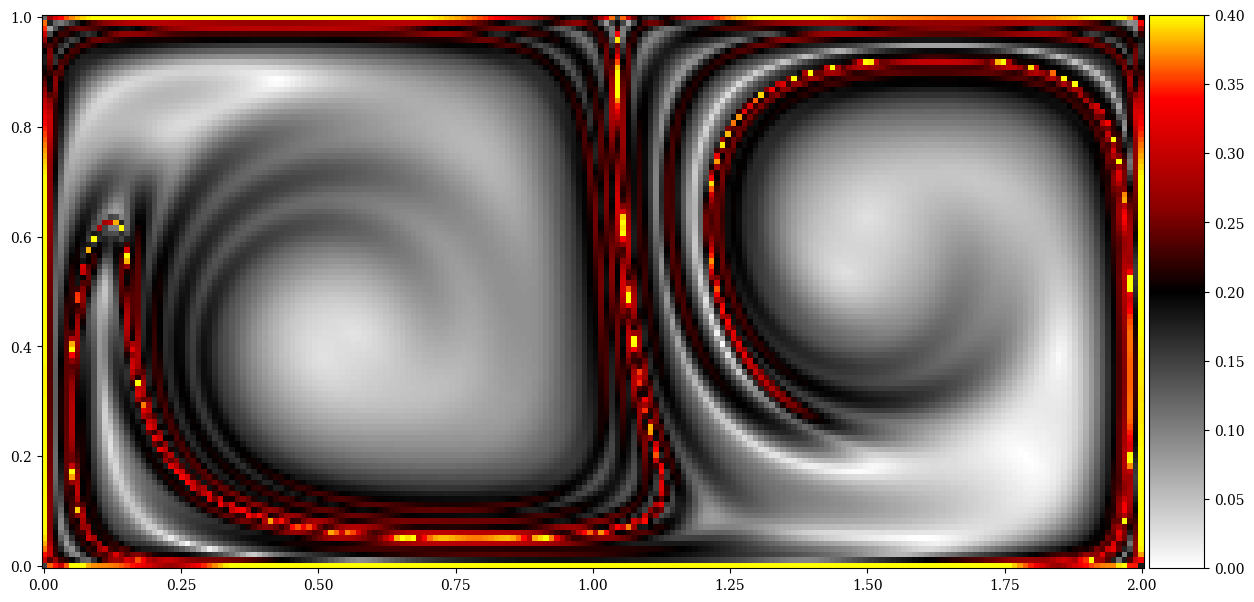

In [ ]:
# Plot the ftle field
clim = [0, 0.4]
fig, ax = plt.subplots()
ftleim = ax.pcolormesh(mesh[0], mesh[1], ftle_field, cmap='gray2hot', vmin=clim[0], vmax=clim[1])
ax.axis('scaled')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
plt.colorbar(ftleim, cax=cax)
plt.show()

## Brief discussion
It is useful to note here that, if the timestep is sufficiently small, there still seems to be 'aliasing' on the FTLE ridge -- that is, it is characterized by jagged peaks in intensity -- that is not apparent when computing FTLEs the traditional way.  This is discussed in greater detail in Harms et al. (2023) and is the result of computing FTLE precisely at the location of the trajectory initial condition with no tacit knowledge of surrounding flow behavior.  Since FTLE ridges are infinitesimally thin material surfaces, there is bound to be an aliasing effect.  Measures of rotational coherence, which tend to be volumetric, do not exhibit this aliasing.  